In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from functools import partial

## set parameters

In [2]:
learning_rate = 0.001

training_epochs = 1
batch_size = 256
display_step = 1

# Network Parameters
### window size for training and test
n_input = 512
n_hidden_1 = 64
n_hidden_2 = 32

examples_to_show = 5
# log directory for tensorboard
log_dir = '/tmp/tensorflow/conv_AE_WAVE/logs'

## create wave form data
トレーニングと評価用に、一次元の波形データを作成します。  
波形は、幾つかの周波数成分を持つサイン波信号にガウス性雑音が加えられたものです。  


In [3]:
### Segment of Wave form : Angle, in radians (2 pi rad equals 360 degrees) 
train_min, train_max = 0, 10000
test_min, test_max = train_max, 12000

resolution = 0.1

### Common Wave form
def base_wave(t):
    return np.sin(t) / 3 + 0.5 * np.sin(t*5) + 0.25 * np.sin(t*10) 
    #return t * np.sin(t)  

### Train wave
def train_time_series(t):
    if t.ndim == 1:
        noise = np.random.rand(len(t))
    elif t.ndim == 2:
        noise = np.random.rand(t.shape[0], t.shape[1])
    else:
        noise = np.random.rand(t.shape[0], t.shape[1], t.shape[2])
    return base_wave(t) + 0.1 * noise

### get a "n_input" length wave randomly
def train_next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (train_max - train_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = train_time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps)


### Anomaly wave for Test wave
anomaly_start = 0.25    # Test wave全体長のおいて、anomaly_start(%)の位置から徐々にanomaly waveが出現
def test_time_series_anomary(t):
    norm = (t - test_min) / (test_max - test_min)
    norm = norm - anomaly_start
    norm = (norm > 0.0) * norm
    return np.sin(t * 20) *  (np.exp(norm) - 1) 


### Test wave
def test_time_series(t):
    if t.ndim == 1:
        noise = np.random.rand(len(t))
    elif t.ndim == 2:
        noise = np.random.rand(t.shape[0], t.shape[1])
    else:
        noise = np.random.rand(t.shape[0], t.shape[1], t.shape[2])
    return base_wave(t) + 0.1 * noise + test_time_series_anomary(t)

### get a "n_input" length wave randomly
def test_next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (test_max - test_min - n_steps * resolution)
    Ts = test_min + t0 + np.arange(0., n_steps + 1) * resolution
    ys = test_time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps)

## plot train data

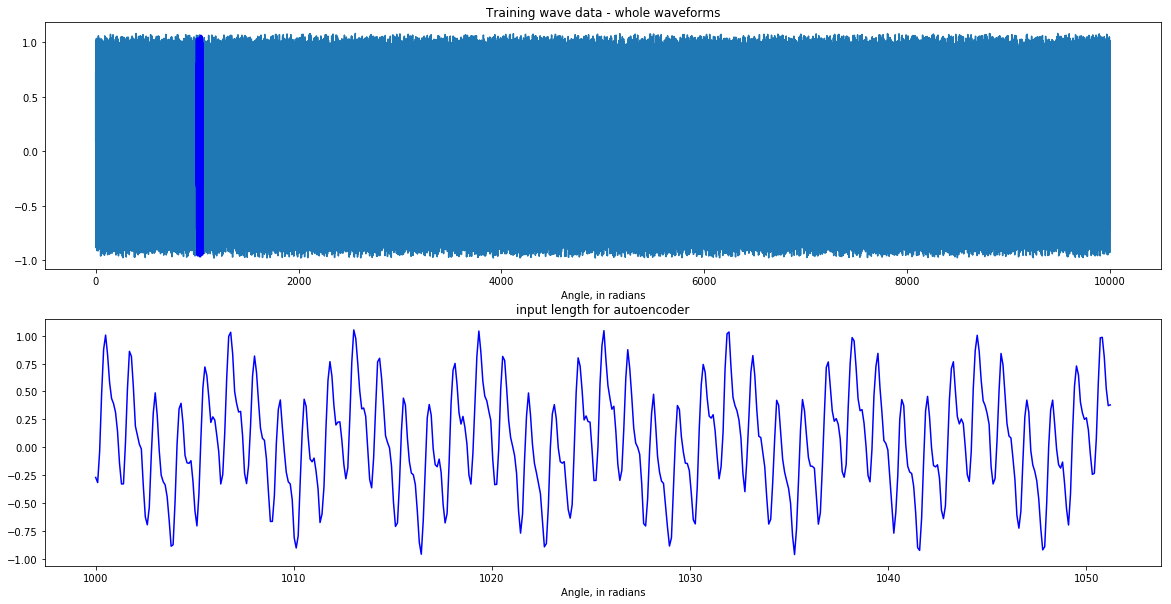

In [4]:
plot_point = 1000   # train_min <= plot_point <= train_max
t = np.linspace(train_min, train_max, int((train_max - train_min) / resolution))
t_instance = np.linspace(plot_point, plot_point + resolution * (n_input + 1), n_input + 1)
wave_size = len(t)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(t, train_time_series(t), label=r"whole waveforms")
plt.plot(t_instance[:-1], train_time_series(t_instance[:-1]), "b-", linewidth=3, label="input length")
plt.title('Training wave data - whole waveforms')
plt.xlabel('Angle, in radians')
plt.subplot(212)
plt.plot(t_instance[:-1], train_time_series(t_instance[:-1]), "b-", label=r"input length")
plt.title('input length for autoencoder')
plt.xlabel('Angle, in radians')

## plot test data

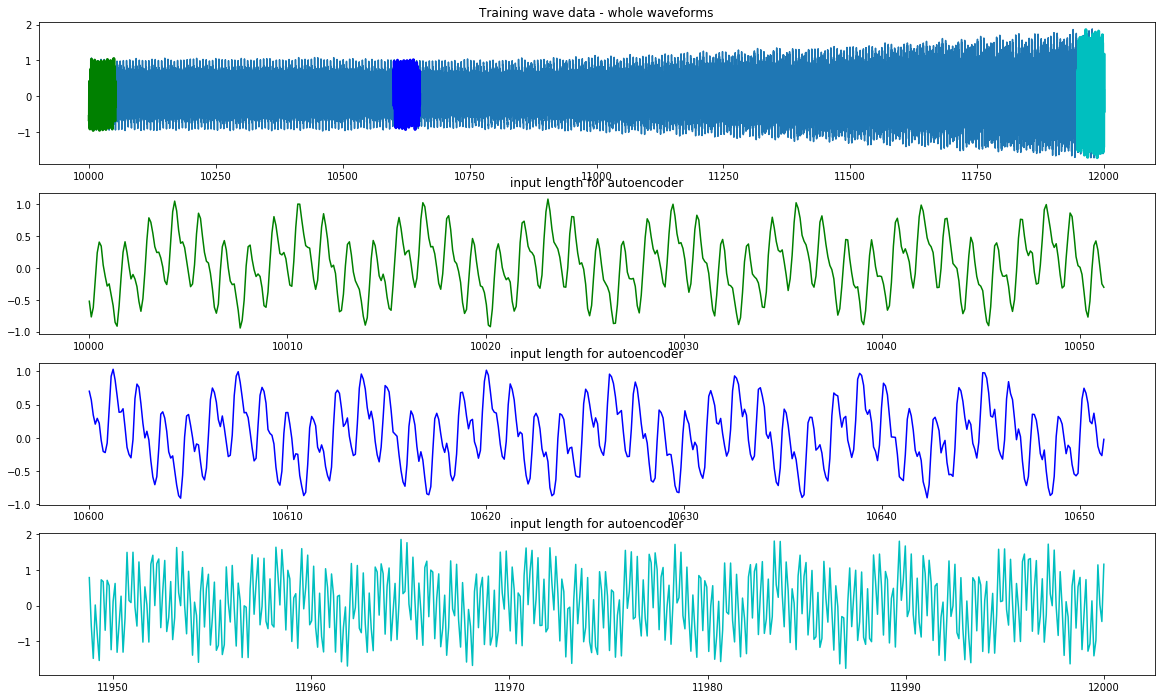

In [5]:
plot_point1 = test_min             # test_min <= plot_point <= test_max
plot_point2 = test_min + 600      # test_min <= plot_point <= test_max
plot_point3 = test_max - n_input * resolution   # test_min <= plot_point <= test_max

t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
t_instance1 = np.linspace(plot_point1, plot_point1 + resolution * (n_input + 1), n_input + 1)
t_instance2 = np.linspace(plot_point2, plot_point2 + resolution * (n_input + 1), n_input + 1)
t_instance3 = np.linspace(plot_point3, plot_point3 + resolution * (n_input + 1), n_input + 1)

plt.figure(figsize=(20,12))
plt.subplot(411)
plt.plot(t, test_time_series(t), label=r"whole wave")
plt.plot(t_instance1[:-1], test_time_series(t_instance1[:-1]), "g-", linewidth=3)
plt.plot(t_instance2[:-1], test_time_series(t_instance2[:-1]), "b-", linewidth=3)
plt.plot(t_instance3[:-1], test_time_series(t_instance3[:-1]), "c-", linewidth=3)
plt.title('Training wave data - whole waveforms')
#plt.xlabel('Angle, in radians')
plt.subplot(412)
plt.plot(t_instance1[:-1], test_time_series(t_instance1[:-1]), "g-")
plt.title('input length for autoencoder')
#plt.xlabel('Angle, in radians')
plt.subplot(413)
plt.plot(t_instance2[:-1], test_time_series(t_instance2[:-1]), "b-")
plt.title('input length for autoencoder')
#plt.xlabel('Angle, in radians')
plt.subplot(414)
plt.plot(t_instance3[:-1], test_time_series(t_instance3[:-1]), "c-")
plt.title('input length for autoencoder')
#plt.xlabel('Angle, in radians')

### Store values for  tensorbord 

In [6]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## 標準layer関数を作成

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。  
また、tensorboardへの表示用の出力も設定する。

In [7]:
def nn_layer(input_tensor, output_dim, name, activation=tf.nn.elu, l2_reg = 0.0005):
    with tf.variable_scope(name):
        
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 
        layer = tf.layers.dense(input_tensor, output_dim, 
                                activation=activation,
                                kernel_initializer=he_init,
                                kernel_regularizer=l2_regularizer)
        
        layer_vars = layer.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

In [8]:
def conv_layer(name, input_tensor, filters, kernel_size, strides=1, padding='valid', activation=tf.nn.elu, l2_reg = 0.005):
    with tf.variable_scope(name):
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 
        layer = tf.layers.conv1d(input_tensor, filters, kernel_size, strides=strides, 
                                 padding=padding, activation=activation,
                                 kernel_initializer=he_init,
                                 kernel_regularizer=l2_regularizer)
        
        layer_vars = layer.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

## decoder部

In [9]:
"""
def encoder(x):
    ### Encoder
    conv1 = conv_layer('enc_conv1', X, 16, (3,1), padding='same', activation=tf.nn.elu)
    # Now 512x1x16
    maxpool1 = tf.layers.max_pooling2d(conv1, (2,1), (2,1), padding='same')
    # Now 256x1x16
    conv2 = conv_layer('enc_conv2', maxpool1, 8, (3,1), padding='same', activation=tf.nn.elu)
    # Now 256x1x8
    maxpool2 = tf.layers.max_pooling2d(conv2, (2,1), (2,1), padding='same')
    # Now 128x1x8
    conv3 = conv_layer('enc_conv3', maxpool2, 8, (3,1), padding='same', activation=tf.nn.elu)
    # Now 128x1x8
    encoded = tf.layers.max_pooling2d(conv3, (2,1), (2,1), padding='same')
    # Now 64x4x8
    return encoded
"""

"\ndef encoder(x):\n    ### Encoder\n    conv1 = conv_layer('enc_conv1', X, 16, (3,1), padding='same', activation=tf.nn.elu)\n    # Now 512x1x16\n    maxpool1 = tf.layers.max_pooling2d(conv1, (2,1), (2,1), padding='same')\n    # Now 256x1x16\n    conv2 = conv_layer('enc_conv2', maxpool1, 8, (3,1), padding='same', activation=tf.nn.elu)\n    # Now 256x1x8\n    maxpool2 = tf.layers.max_pooling2d(conv2, (2,1), (2,1), padding='same')\n    # Now 128x1x8\n    conv3 = conv_layer('enc_conv3', maxpool2, 8, (3,1), padding='same', activation=tf.nn.elu)\n    # Now 128x1x8\n    encoded = tf.layers.max_pooling2d(conv3, (2,1), (2,1), padding='same')\n    # Now 64x4x8\n    return encoded\n"

In [10]:
def encoder(x):
    ### Encoder
    conv1 = conv_layer('enc_conv1', X, 8, 8, padding='same', activation=tf.nn.elu)
    # Now 512x1x8
    pool1 = tf.layers.max_pooling1d(conv1, 4, 4, padding='same')
    # Now 128x1x8
    conv2 = conv_layer('enc_conv2', pool1, 4, 8, padding='same', activation=tf.nn.elu)
    # Now 128x1x4
    encoded = tf.layers.max_pooling1d(conv2, 4, 4, padding='same')
    # Now 32x1x4
    return encoded

## encoder部

In [11]:
"""
def decoder(x):
    upsample1 = tf.image.resize_nearest_neighbor(x, (128,1))
    # Now 128x1x8
    conv4 = conv_layer('dec_conv1', upsample1, 8, (3,1), padding='same', activation=tf.nn.elu)
    # Now 128x1x8
    upsample2 = tf.image.resize_nearest_neighbor(conv4, (256,1))
    # Now 256x1x8
    conv5 = conv_layer('dec_conv2', upsample2, 8, (3,1), padding='same', activation=tf.nn.elu)
    # Now 256x1x8
    upsample3 = tf.image.resize_nearest_neighbor(conv5, (512,1))
    # Now 512x1x8
    conv6 = conv_layer('dec_conv3', upsample3, 16, (3,1), padding='same', activation=tf.nn.elu)
    # Now 512x1x16
    logits = conv_layer('logits', conv6, 1, (3,1), padding='same', activation=None)
    #Now 512x1x1
    return logits
"""    

"\ndef decoder(x):\n    upsample1 = tf.image.resize_nearest_neighbor(x, (128,1))\n    # Now 128x1x8\n    conv4 = conv_layer('dec_conv1', upsample1, 8, (3,1), padding='same', activation=tf.nn.elu)\n    # Now 128x1x8\n    upsample2 = tf.image.resize_nearest_neighbor(conv4, (256,1))\n    # Now 256x1x8\n    conv5 = conv_layer('dec_conv2', upsample2, 8, (3,1), padding='same', activation=tf.nn.elu)\n    # Now 256x1x8\n    upsample3 = tf.image.resize_nearest_neighbor(conv5, (512,1))\n    # Now 512x1x8\n    conv6 = conv_layer('dec_conv3', upsample3, 16, (3,1), padding='same', activation=tf.nn.elu)\n    # Now 512x1x16\n    logits = conv_layer('logits', conv6, 1, (3,1), padding='same', activation=None)\n    #Now 512x1x1\n    return logits\n"

In [12]:
def decoder(x):
    Upsample = tf.contrib.keras.layers.UpSampling1D(size=4)
    upsample1 = Upsample(x)
    # Now 128x1x4
    conv3 = conv_layer('dec_conv3', upsample1, 4, 8, padding='same', activation=tf.nn.elu)
    # Now 128x1x4
    upsample2 = Upsample(conv3)
    # Now 512x4
    conv4 = conv_layer('dec_conv4', upsample2, 8, 8, padding='same', activation=tf.nn.elu)
    # Now 512x1x8
    logits = conv_layer('logits', conv4, 1, 4, padding='same', activation=None)
    #Now 512x1x1
    return logits

### Reset Graph

In [13]:
tf.reset_default_graph()

### グラフを定義

二乗和誤差を用いてロス値を計算する方法

In [14]:
# Construct model
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input, 1])
    
with tf.variable_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.variable_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.variable_scope('prediction'):
    y_pred = decoder_op

# Targets (Labels) are the input data.
with tf.variable_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.variable_scope('reduce_mean'):
    #cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    cost = tf.reduce_mean(tf.square(y_true - y_pred))
tf.summary.scalar('reduce_mean', cost)


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### グラフを定義

コスト関数：シグモイド＆クロスエントロピー誤差を用いてロス値を計算する方法

一次元Wave dataの場合、こちらのロス計算法を利用すると性能が悪かったので現状は不採用

In [15]:
"""
# Construct model
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input, 1])
    
with tf.name_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.name_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.name_scope('prediction'):
    y_pred = tf.nn.sigmoid(decoder_op)

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reduce_mean'):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=decoder_op)
    cost = tf.reduce_mean(loss)
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
"""

"\n# Construct model\nwith tf.variable_scope('input'):\n    X = tf.placeholder(tf.float32, [None, n_input, 1])\n    \nwith tf.name_scope('encoder_part'):\n    encoder_op = encoder(X)\n\nwith tf.name_scope('decoder_part'):\n    decoder_op = decoder(encoder_op)\n\n# Prediction\nwith tf.name_scope('prediction'):\n    y_pred = tf.nn.sigmoid(decoder_op)\n\n# Targets (Labels) are the input data.\nwith tf.name_scope('target'):\n    y_true = X\n\n# Define loss and optimizer, minimize the squared error\nwith tf.name_scope('reduce_mean'):\n    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=decoder_op)\n    cost = tf.reduce_mean(loss)\ntf.summary.scalar('reduce_mean', cost)\n\n\nwith tf.name_scope('train'):\n    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)\n"

## Training & Evaluation

Epoch: 0001 cost= 0.166243434
Optimization Finished!


/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


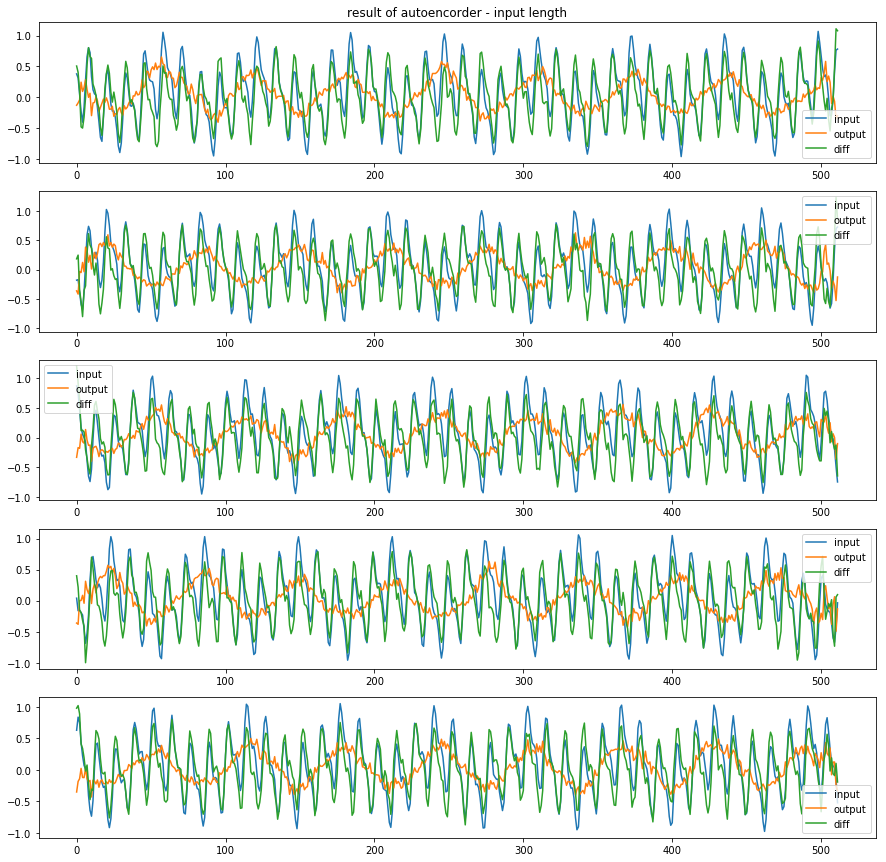

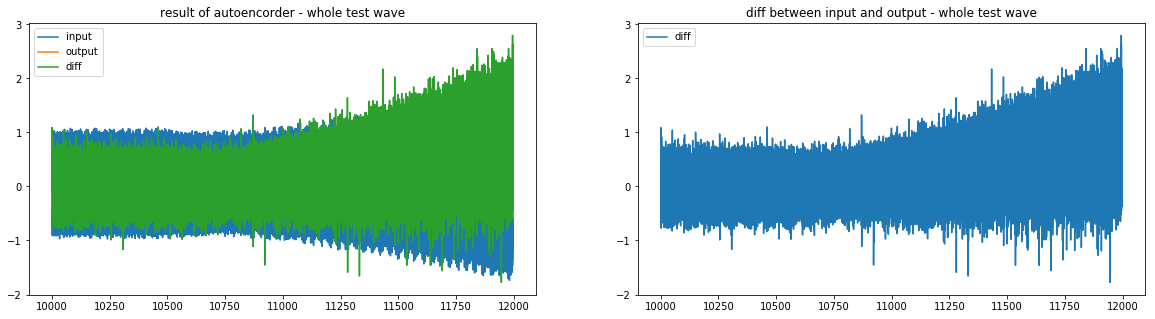

In [16]:
# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

saver = tf.train.Saver()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(log_dir + '/summaries/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/summaries/test')

    total_batch = int(wave_size/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch = train_next_batch(batch_size, n_input)
            batch_xs = batch.reshape((-1, n_input, 1))
            
            # Run optimization op (backprop) adn cost op (to get loss value)
            summary, _, c = sess.run([merged, optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            sys.stdout.flush()
        train_writer.add_summary(summary, epoch)
    print("Optimization Finished!")
    train_writer.close()
    test_writer.close()
    saver.save(sess, log_dir + "model/my_model")

    # Plot wave form : result of autoencorder - input length
    batch = batch_xs = train_next_batch(examples_to_show, n_input)
    batch_xs = batch.reshape((-1, n_input, 1))
    
    train_encode_decode = sess.run(y_pred,
                             feed_dict={X: batch_xs})
    # Compare original images with their reconstructions
    f, a = plt.subplots(examples_to_show, 1, figsize=(15, 15))
    for i in range(examples_to_show):
        a[i].plot(batch_xs[i], label='input')
        a[i].plot(train_encode_decode[i], label='output')
        a[i].plot(batch_xs[i] - train_encode_decode[i], label='diff')
        a[i].legend()
        a[0].set_title('result of autoencorder - input length')
    f.show()
    
    # Plot wave form : result of autoencorder - whole test wave
    t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
    n_data = int(len(t) / n_input) * n_input
    x_batch = t[:n_data].reshape(-1, n_input, 1)
    test_encode_decode = sess.run(y_pred,
                             feed_dict={X: test_time_series(x_batch)})
    
    f, a = plt.subplots(1, 2, figsize=(20, 5))
    input_wave = test_time_series(x_batch.reshape(-1,1))
    output_wave = test_encode_decode.reshape(-1,1)
    a[0].plot(t[:n_data], input_wave, label='input')
    a[0].plot(t[:n_data], output_wave, label='output')
    a[0].plot(t[:n_data], output_wave - input_wave, label='diff')
    a[0].legend()
    a[0].set_title('result of autoencorder - whole test wave')
    a[1].plot(t[:n_data], output_wave - input_wave, label='diff')
    a[1].legend()
    a[1].set_title('diff between input and output - whole test wave')
    

sess.close()

## クラスタリング

中間層の出力をTensorboardでクラスタリングしてみます。

入力：テストデータ
embeddingデータ： 中間層のデータ

結果としては、クラスタリングが上手くできませんでした。
理由としては、トレーニングデータのみで学習していることが考えられます。
トレーニングデータと異なる特徴のテストデータを入力とし、中間層を取り出したとしても、
表現できるのはトレーニングデータで学習した特徴のみが中間層で表現されているためだと思われます。

In [17]:
import os
from tensorflow.contrib.tensorboard.plugins import projector

In [18]:

# Plot wave form : result of autoencorder - whole test wave
t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
n_data = int(len(t) / n_input) * n_input
x_batch = t[:n_data].reshape(-1, n_input, 1)
n_batch = x_batch.shape[0]

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, log_dir + "model/my_model") # not shown
    hidden_tmp = sess.run(encoder_op,
                      feed_dict={X: test_time_series(x_batch)})

INFO:tensorflow:Restoring parameters from /tmp/tensorflow/conv_AE_WAVE/logsmodel/my_model


In [19]:
hidden = hidden_tmp.reshape(n_batch,-1)

In [20]:
hidden.shape

(39, 128)

### メタデータファイルの作成

メタデータファイルは、  
* 最初の行にカラム名を記述  
* メタ情報を2行目以降に記述  

例えば、MNISTの画像のメタデータを作る場合は、以下のように最初のカラムにインデックス、次のカラムにラベル名（数字）を指定します。

In [21]:
# 
#LOG_DIR = "/tmp/tensorflow/conv_AE_WAVE/logs"

# recreate log directory
if tf.gfile.Exists(log_dir + '/projector'):
    tf.gfile.DeleteRecursively(log_dir + '/projector')
tf.gfile.MakeDirs(log_dir + '/projector')

In [22]:
n_class = 10
n_cluster = hidden.shape[0]
n_each_class_data = int(n_cluster / n_class + 1)

with open(os.path.join(log_dir, 'projector/metadata.tsv'),'w') as f:
    #f.write("Index\tLabel\n")
    for i in np.arange(n_cluster):
        label = int(i / n_each_class_data)
        f.write('{}\n'.format(label))

### クラスタ用のembeddingを保存

In [23]:


xs = tf.stack(hidden, axis=0)

with tf.variable_scope('hidden_embedding'):
    embedding_var = tf.Variable(xs, trainable=False, name='embedding')


summary_writer = tf.summary.FileWriter(os.path.join(log_dir, 'projector'), sess.graph)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# metadata 
embedding.metadata_path = os.path.join(log_dir, 'projector/metadata.tsv')

# stripe 
#embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
#embedding.sprite.single_image_dim.extend([28,28])

projector.visualize_embeddings(summary_writer, config)


#sess = tf.InteractiveSession()

# initialize "embedding_ver"
init = tf.variables_initializer([embedding_var])

with tf.Session() as sess:
    sess.run(init)
    # specify variable to save 
    saver = tf.train.Saver([embedding_var])
    # save variables 
    saver.save(sess, os.path.join(log_dir, "projector/model.ckpt"), global_step=n_data)

## Tensorboard 起動

tensorboard --logdir=/tmp/tensorflow/tensorboard

In [25]:
!tensorboard --logdir=/tmp/tensorflow/conv_AE_WAVE

Starting TensorBoard b'54' at http://shinya-no-MacBook-Pro.local:6006
(Press CTRL+C to quit)
^C
